In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras import backend as keras

Using TensorFlow backend.


In [2]:
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import random




In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
img_path = '/content/gdrive/My Drive/Images'

In [5]:
img_path

'/content/gdrive/My Drive/Images'

In [6]:
msk_path = '/content/gdrive/My Drive/Masks'

In [7]:
im = os.listdir(img_path)

In [8]:
len(im)

3928

In [9]:
msk = os.listdir(msk_path)

In [10]:
len(msk)

3928

In [15]:
X = np.zeros((1000, 256, 256, 3), dtype=np.float32)
y = np.zeros((1000, 256, 256,1), dtype=np.float32)

In [17]:
c = 0
for i in im[:1000]:
  img = imread(img_path+'/'+i)
  img1 = resize(img, (256, 256, 3), mode = 'constant', preserve_range = True)
  u = i.split('.')[0]
  mask = imread(msk_path+'/'+u+'_mask.tif')
  mask1 = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
  X[c] = img1/255.0
  y[c] = mask1/255.0
  c = c+1



In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)


In [19]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
def unet_model(ip_size=(256,256,3)):
  inputs = Input(ip_size)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  pool1 = Dropout(0.2)(pool1)

  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  pool2 = Dropout(0.2)(pool2)

  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  pool3 = Dropout(0.25)(pool3)

  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  pool4 = Dropout(0.25)(pool4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)


  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
  
  model = Model(input = inputs, output = conv10)

  return model


In [21]:
model = unet_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [22]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  

In [24]:
callbacks = [
    EarlyStopping(patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [25]:
results = model.fit(X_train, y_train, batch_size=16,validation_data=(X_valid, y_valid), epochs=40, callbacks=callbacks)

Train on 700 samples, validate on 300 samples
Epoch 1/40
700/700 [==============================] - 55s 79ms/step - loss: 0.0966 - accuracy: 0.9691 - val_loss: 0.0356 - val_accuracy: 0.9878

Epoch 00001: val_loss improved from inf to 0.03557, saving model to model-brain-mri.h5
Epoch 2/40
700/700 [==============================] - 38s 55ms/step - loss: 0.0313 - accuracy: 0.9902 - val_loss: 0.0255 - val_accuracy: 0.9924

Epoch 00002: val_loss improved from 0.03557 to 0.02546, saving model to model-brain-mri.h5
Epoch 3/40
700/700 [==============================] - 38s 55ms/step - loss: 0.0281 - accuracy: 0.9915 - val_loss: 0.0304 - val_accuracy: 0.9923

Epoch 00003: val_loss did not improve from 0.02546
Epoch 4/40
700/700 [==============================] - 38s 55ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0274 - val_accuracy: 0.9905

Epoch 00004: val_loss did not improve from 0.02546
Epoch 00004: early stopping


In [26]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.027423434183001517
Test accuracy: 0.9905226826667786


In [27]:
preds_val = model.predict(X_valid, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

300/300 [==============================] - 5s 17ms/step


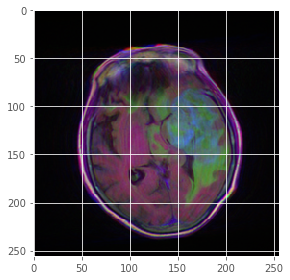

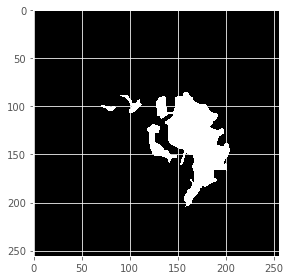

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


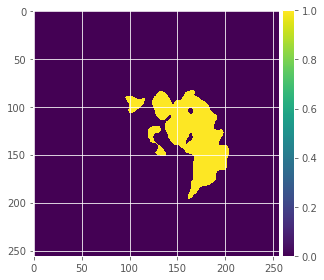

In [48]:
ids = random.randint(0,300)
imshow(X_valid[ids])
plt.show()
imshow(np.squeeze(y_valid[ids]))
plt.show()
imshow(np.squeeze(preds_val_t[ids]))
plt.show()